<a href="https://colab.research.google.com/github/mahault/Multi-agent-sustainability/blob/main/Sust_AIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sustainability under AIF - simulation**

*Mahault Albarracin, Maria Raffa*

-----
*Based on Sussex University ICAM Lab's hints*

In order to deal with sustainability in a very straightforward way, i.e. an agent is able to sustain itself by learning how to use the resources at its disposal wisely, we could think of a simple model: an agent that is in a certain place and has to decide whether or not to eat food that is in the same place at different time steps.

In this sense, the agent acts in a sustainable way because it learns that it does not have to satisfy its greed immediately, even if it is very hungry, because the aim is to maintain a balance between itself and the environment (i.e. a room with food) as long as possible over time. In this case, it learns to align available resources with its needs.

The following code in progress (**Case 1**) is just for an agent deciding whether to eat food or not. It should result in an agent that keeps eating, in an environment where food is always present. We assume the agent is aware of its own location and knows that food is in the same location as it is as well, so it has perfect knowledge of the environment.

In a second phase, the agent should learn how to not be greedy over time, in an environment that has changed, i.e. food that has been eaten then appears again after x time steps (this might be done by adding dimensions to the hidden state and observation food_left - **Case 2**).

In [ ]:
# Import necessary libraries
!pip install inferactively-pymdp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymdp
from pymdp.agent import Agent #
from pymdp import inference, control, learning
from pymdp import utils, maths
from pymdp.maths import softmax

# **Case 1**
-----
The environment does not change: the food is present and the agent just decides whether to eat or not.

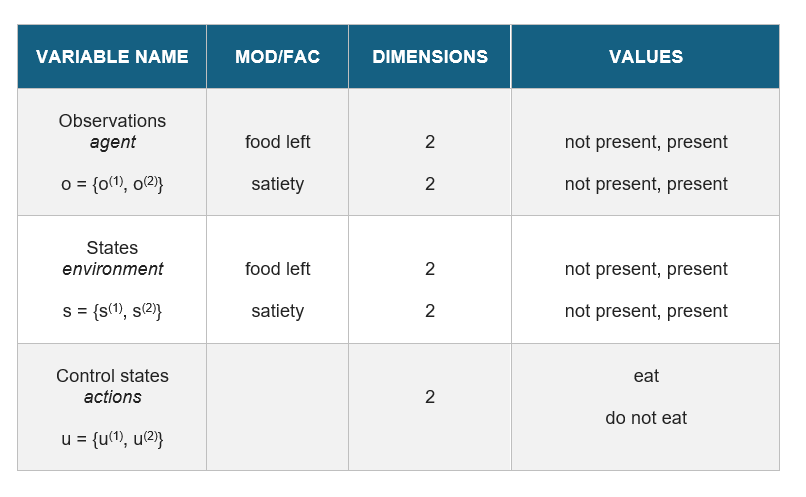

Not sure about satiety as hidden state

## **Generative model**

In [ ]:
# observations
obs_food = ['not present', 'present']
obs_satiety = ['no', 'yes']

#states
s_food = ['not present', 'present'] #0
s_satiety = ['no', 'yes']           #1

#controls
action0 = ['do not eat']
action1 = ['eat']

In [ ]:
#observation modality dimensions
num_obs = [len(obs_food), len(obs_satiety)]

#hidden state factors dimensions
num_states = [len(s_food), len(s_satiety)]

#control state factor dimensions
num_controls = [len(action0), len(action1)]

In [ ]:
num_obs

[2, 2]

In [ ]:
num_states

[2, 2]

In [ ]:
num_controls

[1, 1]

In [ ]:
# B_factor_list says the states each state depends on
# 0 (food state), 1 (satiety state)
#B_factor_list=[[0,1],[0]] #is it necessary?

###**A Matrix**

In [ ]:
#we need 2 matrices, one for each obs
#chek the following, something is missing

In [ ]:
#label every column/row to understand what do the matrices mean
#fill in by hand

# This is a scenario where there is complete certainty
# Define the size of each dimension
num_obs_types = 2   # 'food left' and 'satiety'
num_obs_values = 2  # 'not present/present' and 'no/yes'
num_s_food_values = 2   # 'not present', 'present'
num_s_satiety_values = 2 # 'no', 'yes'

# Initialize the observation model A
A = np.zeros((num_obs_types, num_obs_values, num_s_food_values, num_s_satiety_values))

# Mapping food observations based on the state of food
A[0, 0, 0, :] = 1.0  # If food is 'not present' (state), observe 'not present' (100%)
A[0, 1, 1, :] = 1.0  # If food is 'present' (state), observe 'present' (100%)

# Mapping satiety observations based on the state of satiety
A[1, 0, :, 0] = 1.0  # If satiety is 'no' (state), observe 'no' (100%)
A[1, 1, :, 1] = 1.0  # If satiety is 'yes' (state), observe 'yes' (100%)


In [ ]:
# Print the A matrix
A[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

In [ ]:
A[1]

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

In [ ]:
A[0][:,:,1]

array([[1., 0.],
       [0., 1.]])

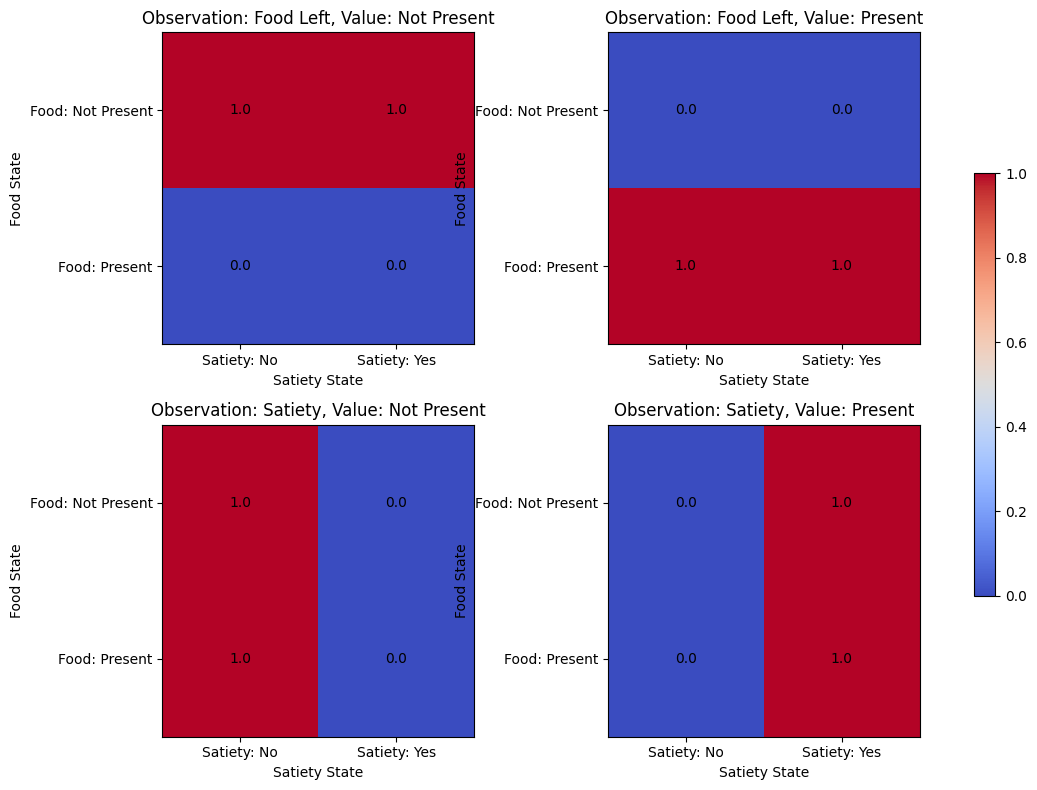

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
obs_types = ['Food Left', 'Satiety']
obs_values = ['Not Present', 'Present']
state_labels_food = ['Food: Not Present', 'Food: Present']
state_labels_satiety = ['Satiety: No', 'Satiety: Yes']

for obs_index in range(num_obs_types):  # Loop over observation types
    for value_index in range(num_obs_values):  # Loop over observation values
        ax = axes[obs_index, value_index]
        matrix_slice = A[obs_index, value_index, :, :]
        im = ax.imshow(matrix_slice, cmap='coolwarm', vmin=0, vmax=1)
        ax.set_xticks(np.arange(num_s_satiety_values))
        ax.set_yticks(np.arange(num_s_food_values))
        ax.set_xticklabels(state_labels_satiety)
        ax.set_yticklabels(state_labels_food)
        ax.set_title(f'Observation: {obs_types[obs_index]}, Value: {obs_values[value_index]}')
        ax.set_xlabel('Satiety State')
        ax.set_ylabel('Food State')

        # Add text annotations for clarity
        for i in range(num_s_food_values):
            for j in range(num_s_satiety_values):
                text = ax.text(j, i, f'{matrix_slice[i, j]:.1f}',
                               ha="center", va="center", color="black")

fig.tight_layout()
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.show()


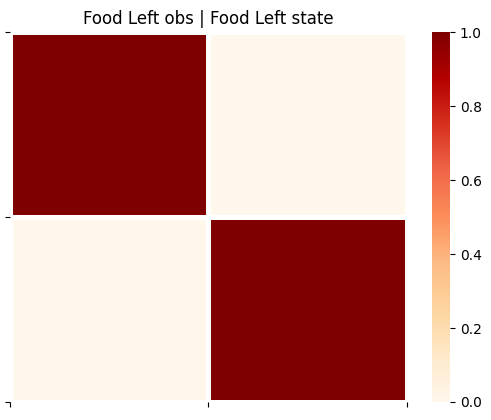

In [ ]:
utils.plot_likelihood(A[0][:, :, 0], title='Food Left obs | Food Left state')

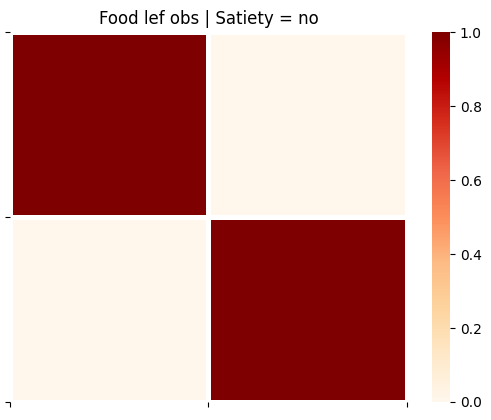

In [ ]:
utils.plot_likelihood(A[0][:,:,0], title = "Food lef obs | Satiety = no")

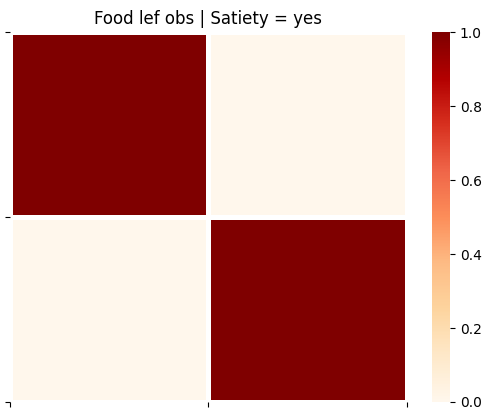

In [ ]:
utils.plot_likelihood(A[0][:,:,1], title = " Food left obs | Satiety = yes")

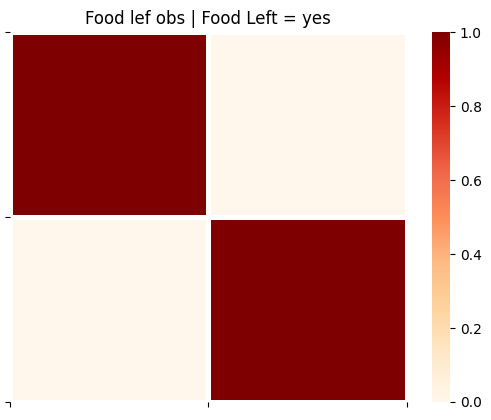

In [ ]:
utils.plot_likelihood(A[0][:,:,1], title = "Food lef obs | Food Left = yes")

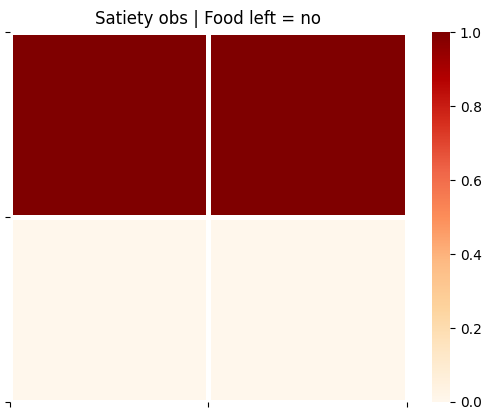

In [ ]:
utils.plot_likelihood(A[1][:,:,0], title = "Satiety obs | Food left = no")

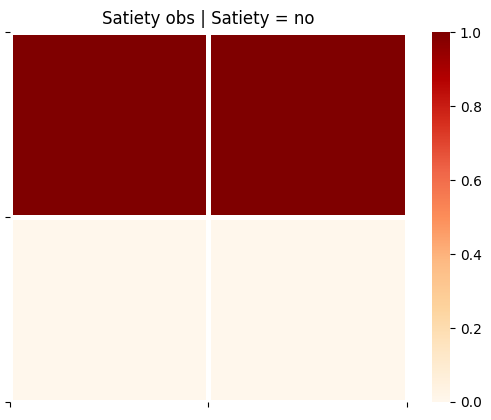

In [ ]:
utils.plot_likelihood(A[1][:,:,0], title = "Satiety obs | Satiety = no")

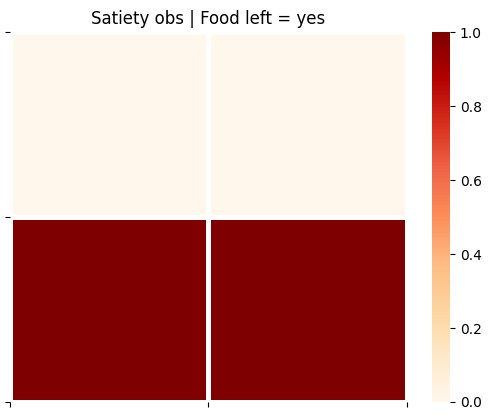

In [ ]:
utils.plot_likelihood(A[1][:,:,1], title = "Satiety obs | Food left = yes")

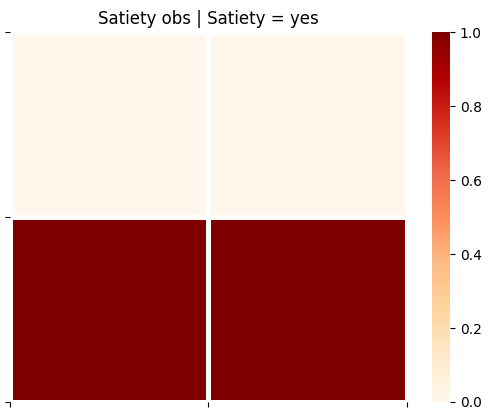

In [ ]:
utils.plot_likelihood(A[1][:,:,1], title = "Satiety obs | Satiety = yes")

following commented stuff did not work

In [ ]:
#A = utils.initialize_empty_A(num_obs, num_states)

In [ ]:
#A_dims = num_obs + num_states

In [ ]:
#A_dims

[2, 2, 2, 2]

In [ ]:
#observation food

#p_food = 1. #confidence in observing food

#A_food = np.zeros((len(obs_food), len(s_food))) #matrix bi dimensional  is ok?

#A_food

array([[0., 0.],
       [0., 0.]])

In [ ]:
#for food_id, s_food_value in enumerate(s_food):

 # if s_food_value == 'not present':
  #  A_food[0, food_id] = 1.0

  #elif s_food_value == 'present':
   # A_food[1, food_id] = np.array([[p_food,    1.0 - p_food], #error
                              #   [1.0 - p_food, p_food]])

  #A[0] = A_food

In [ ]:
#prob_A = 1. #confidence in A matrix

#### A matrix with one hidden state only i.e. food left

In [ ]:
# Define the size of each dimension
num_obs_types = 2  # 'food left' and 'satiety'
num_obs_values = 2 # 'not present/present' and 'no/yes'
num_s_food_values = 2 # 'not present', 'present'

# Initialize the observation model A
A = np.zeros((num_obs_types, num_obs_values, num_s_food_values))

# Mapping food observations based on the state of food
A[0, 0, 0] = 1.0  # Observe 'not present' when food is 'not present' (100% certainty)
A[0, 1, 1] = 1.0  # Observe 'present' when food is 'present' (100% certainty)

# Mapping satiety observations based on the state of food
# Assuming some dependency model where the presence of food might affect perceived satiety
A[1, 0, 0] = 0.8  # More likely to observe 'no' satiety when food is 'not present'  #or just set everything 0.5?
A[1, 1, 0] = 0.2  # Less likely to observe 'yes' satiety when food is 'not present'
A[1, 0, 1] = 0.3  # Less likely to observe 'no' satiety when food is 'present'
A[1, 1, 1] = 0.7  # More likely to observe 'yes' satiety when food is 'present'

# Print the A matrix
A

array([[[1. , 0. ],
        [0. , 1. ]],

       [[0.8, 0.3],
        [0.2, 0.7]]])

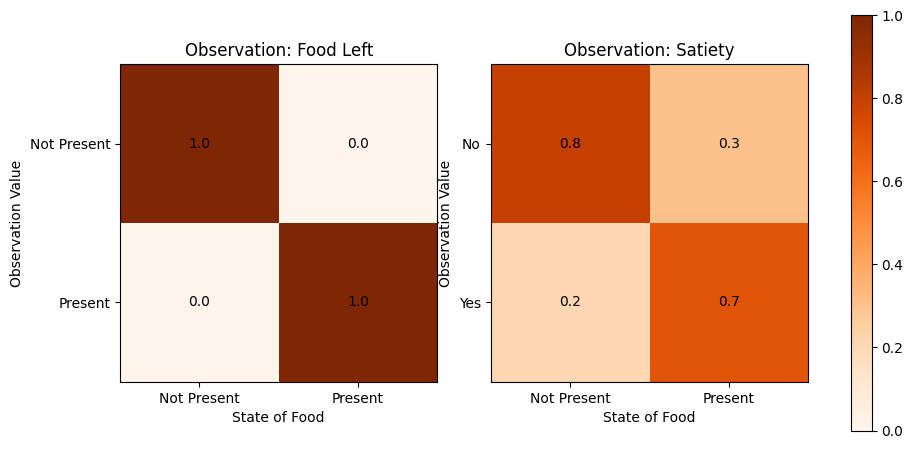

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
obs_labels = ['Food Left', 'Satiety']
state_labels = ['Not Present', 'Present']

for i, ax in enumerate(axes):
    c = ax.imshow(A[i], cmap='Oranges', vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(state_labels)))
    ax.set_yticks(np.arange(len(state_labels)))
    ax.set_xticklabels(state_labels)
    ax.set_yticklabels(['No', 'Yes'] if i else ['Not Present', 'Present'])
    ax.set_title(f'Observation: {obs_labels[i]}')
    ax.set_xlabel('State of Food')
    ax.set_ylabel('Observation Value')

    # Loop over data dimensions and create text annotations.
    for j in range(len(state_labels)):
        for k in range(len(state_labels)):
            text = ax.text(k, j, f'{A[i, j, k]:.1f}',
                           ha="center", va="center", color="black")

fig.tight_layout()
plt.colorbar(c, ax=axes.ravel().tolist(), shrink=0.95)
plt.show()

###**B Matrix**

In [ ]:
# create transition likelihood (B matrix)
B = utils.random_B_matrix(num_states, num_controls) #, B_factor_list=B_factor_list)
prob_B = 1. # confidence in B matrix

In [ ]:
#we need one matrix for each control state (action)
B_do_not_eat = np.zeros( (len(s_food), len(s_food), len(action0)) )

B_do_not_eat[:,:,0] = np.eye(len(action0))

B[0] = B_do_not_eat

In [ ]:
B[0]

array([[[1.],
        [1.]],

       [[1.],
        [1.]]])

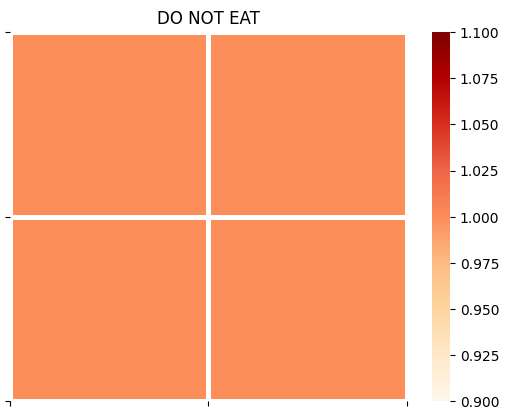

In [ ]:
utils.plot_likelihood(B[0][:,:,0], title = 'DO NOT EAT') #wrong, this is like everything id 0.5 prob

In [ ]:
B_eat = np.zeros( (len(s_satiety), len(s_satiety), len(action1)))

B_eat[:,:,0] = np.eye(len(action1)) #check whether it is correct

B[1] = B_eat

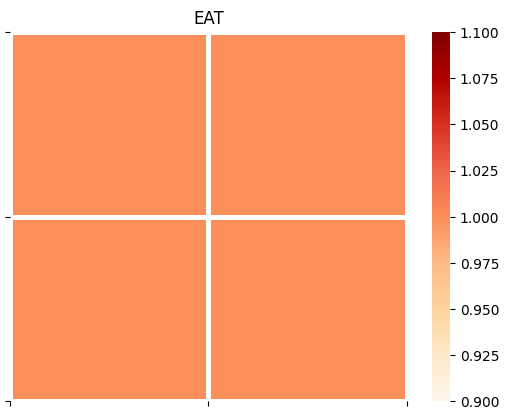

In [ ]:
utils.plot_likelihood(B[1][:,:,0], title = 'EAT')  #wrong, this is like everything id 0.5 prob

Again, let's wrap that into a quick `create_B()` function so we can re-set it whenever we want.

### **C and D vectors**

In [ ]:
#create prior preferences over observations (C vector)
C = utils.obj_array_uniform([num_obs]) #wrong, all the same prob
C

array([array([[0.5, 0.5],
              [0.5, 0.5]])], dtype=object)

In [ ]:
C.shape

(1,)

In [ ]:
#specify prior over hidden states (D vector) #how's the world at t0
D = utils.obj_array(1)
D[0] = utils.onehot(1, num_states)
D

array([array([[0., 0.],
              [1., 1.]])], dtype=object)

In [ ]:
D.shape

(1,)

TypeError: only length-1 arrays can be converted to Python scalars

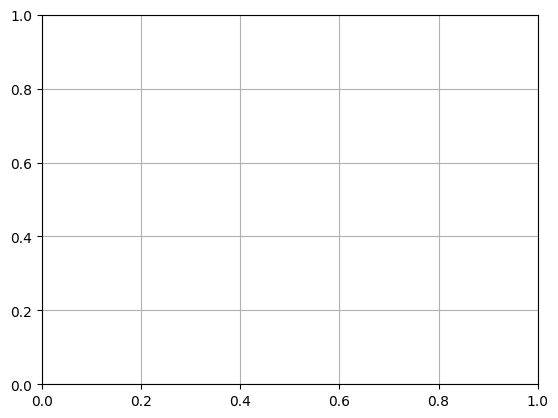

In [ ]:
utils.plot_beliefs(softmax(D[0]), title = "Prior beliefs about probability of ? ")

### **Agent**

In [ ]:
#my_agent = Agent (A=A, B=B, C=C, D=D)

### **AIF loop**

# **Case 2**
-----
The environment changes: food that is eaten then appears again after x time steps.The agent should learn how to not be greedy over time.
This might be done by giving more dimensions to hidden states *food_left* and *satiety*?



# **Previous attempts**

----

## **First attempts**
Dimensionalities of the hidden state factors and the control states

In [ ]:
""" Define dimensionalities of the hidden state factors and control state factors """ #my hidden state: 1 (food [0,1])
num_states = [1, 1] # a list of dimensionalities of the hidden state factor
num_factors = len(num_states) # the total number of hidden state factors

num_controls = [2, 2] # a list of the dimensionalities of each control state factor. my control states: 2 (eat, do not eat)
num_control_factors = len(num_controls) # the total number of control states factors

In [ ]:
num_factors

2

In [ ]:
num_states

[1, 1]

In [ ]:
B = utils.initialize_empty_B(num_states, num_controls)

B[0].shape #1 room and 2 actions

(1, 1, 2)

In [ ]:
B[1].shape

(1, 1, 2)

**2 Matrix A**

*2.1 From Heins' nb multi-armed*

Let's start with a **single observation modality**, i.e. food left



 But the following considers 1 obs (food_left). What about obs satiety? How do we add it?

In [ ]:
num_obs = [3] #only 1 obs
num_modalities = len(num_obs)

A = utils.initialize_empty_A(num_obs, num_states)
A_food_left_dims = num_obs + num_states

In [ ]:
num_modalities

1

In [ ]:
A_food_left_dims

[3, 1, 1]

In [ ]:
A[0].shape

(3, 1, 1)

In [ ]:
#is this the correct way to populate it?

A[0][0,:,0] = np.eye(1)

#A[0][1,:,1] = np.eye(1)

#A[0][2,:,2] = np.eye(1)

Filling out the entries

In [ ]:
np.eye(1)

array([[1.]])

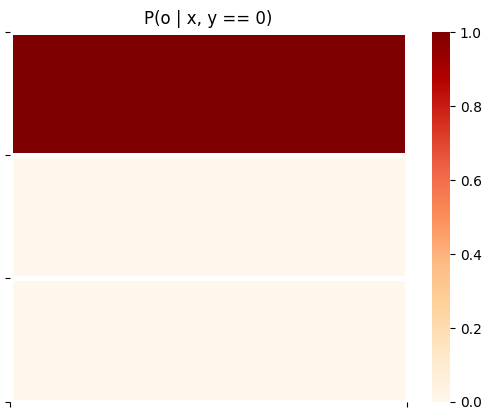

In [ ]:
utils.plot_likelihood(A[0][:,:,0], title = "P(o | x, y == 0)") #title? meaning?

In [ ]:
#utils.plot_likelihood(A[0][:,:,1], title = "P(o | x, y == 1)" )

*2.2 OR from pymdp paper*

In [ ]:
#create a simple model with 1 hidden state factor and 1 observation modality
n_obs = 3 #food_left
n_states = 3
A = utils.obj_array(1)

In [ ]:
A.shape

(1,)

In [ ]:
#This is just with 1 obs, but we have 2
A[0] = np.array ([[1.0, 0.0, 0.0] ,
                  [0.0, 1.0, 0.0] ,
                  [0.0, 0.0, 1.0]])

In [ ]:
#introduce uncertainty into the hidden state
food_left = 0.5
A[0][:,2] = maths.softmax(food_left* A[0] [:,2])

In [ ]:
#utils.plot_likelihood(A[0][:,2], title = "foo" ) #cannot plot since is 2D

**3. Matrix B**

*3.1 From Heins' nb* - failed

In [ ]:
""" Build an object array for storing the factor-specific B matrices """
#B = utils.initialize_empty_B(num_states, num_controls) #transition model

In [ ]:
#B[0].shape #1 location, 2 control states (eat, do not eat)

In [ ]:
#B #empty, to be filled in

In [ ]:
#for f, ns in enumerate(num_states):

 # """ Initialize the B matrix for this factor """
  #B[f] = np.zeros((ns, ns, num_controls[f]))

#EAT
#B[f][ , , 0] = 1.0
#B[f][ , , ] =

#DO NOT EAT
#B[f][:, : , 1] = np.eye(ns)

*3.2 From pymdp paper*

In [ ]:
# create a simple transition model with two possible actions

B = utils.obj_array (1)
B[0] = np.zeros ((3, 3, 2)) #n_obs = 3 (we're considering obs food_left for 3 dim); n_states = 3 (only 1 hidden state); control state = 2 (eat, do not)


# DO NOT EAT leads to first 2 states with uncertainty

B [0][: ,: ,0] = np. array ([[0.5 , 0.5 , 0.5] ,
                             [0.5 , 0.5 , 0.5] ,
                             [0.0 , 0.0 , 0.0]])

# EAT leads to state with certainty: food_left = 0

B [0][: ,: ,1] = np. array ([[0.0 , 0.0 , 0.0] ,
                             [0.0 , 0.0 , 0.0] ,
                             [1.0 , 1.0 , 1.0]])




In [ ]:
B

array([array([[[0.5, 0. ],
               [0.5, 0. ],
               [0.5, 0. ]],

              [[0.5, 0. ],
               [0.5, 0. ],
               [0.5, 0. ]],

              [[0. , 1. ],
               [0. , 1. ],
               [0. , 1. ]]])], dtype=object)

In [ ]:
B[0].shape

(3, 3, 2)

In [ ]:
B.sum(axis = 0)

array([[[0.5, 0. ],
        [0.5, 0. ],
        [0.5, 0. ]],

       [[0.5, 0. ],
        [0.5, 0. ],
        [0.5, 0. ]],

       [[0. , 1. ],
        [0. , 1. ],
        [0. , 1. ]]])

Plot the B matrix

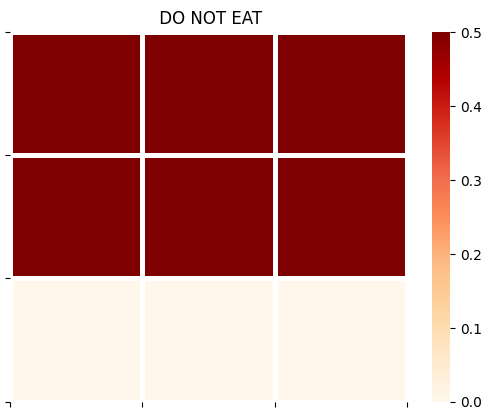

In [ ]:
utils.plot_likelihood(B[0][:,:,0], title = 'DO NOT EAT') #  #this action takes uncertainty: the agent is not sure what's gonna happen if it does not eat

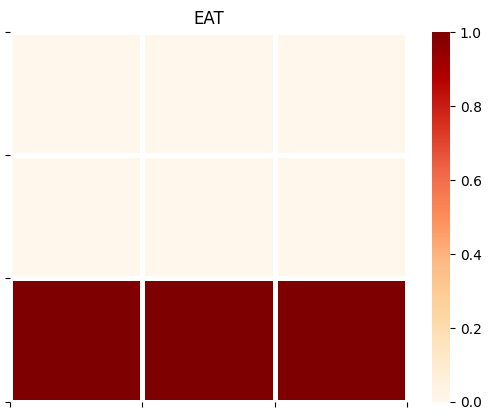

In [ ]:
utils.plot_likelihood(B[0][:,:,1], title = 'EAT') #eat will bring to smth certain: food_left = 0

**4. Vectors C - D**


 this considers 1 obs (food_left). What about obs satiety? How do we add it?

*From pymdp paper*


In [ ]:
from pymdp.maths import softmax

In [ ]:
#specify prior preferences (C vector)
C = utils.obj_array_uniform([n_obs]) #specified where?
C

array([array([0.33333333, 0.33333333, 0.33333333])], dtype=object)

In [ ]:
C.shape

(1,)

In [ ]:
#plot?
#utils.plot_beliefs(softmax(C), title = "Prior preferences")

In [ ]:
#specify prior over hidden states (D vector) #how's the world at t0
D = utils.obj_array(1)
D[0] = utils.onehot(1, n_states)
D

array([array([0., 1., 0.])], dtype=object)

In [ ]:
D.shape

(1,)

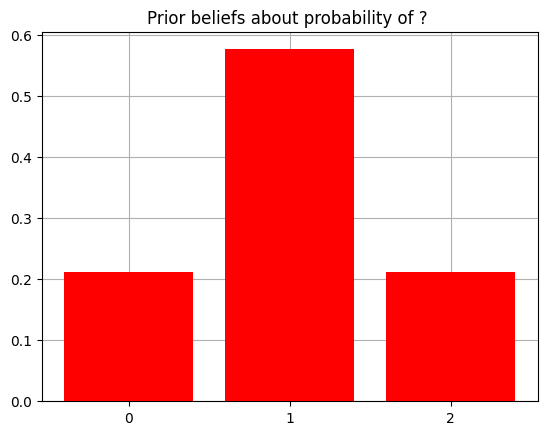

In [ ]:
#plot? understand what it means
utils.plot_beliefs(softmax(D[0]), title = "Prior beliefs about probability of ? ")

In [ ]:
# instantiate the agent
my_agent = Agent (A=A, B=B, C=C, D=D)

**5. Another generative model**

As above, this considers 1 obs (food_left). What about obs satiety? How do we add it?

*5.1 From pymdp paper*

In [ ]:
# write a simple environment class, where state depends on the action
# probabilistically and observation is deterministic function of the state
# except for state 2, where it’s randomly sampled %%

from pymdp.envs import Env

In [ ]:
# sub - class it from the base Env class
class custom_env(Env):

  def __init__(self):
    self.state = 0

  def step(self, action):

    if action == 0: #NOT EAT = uncertainty
      self.state == 0 if np.random.rand() > 0.5 else 1

    if action == 1: #EAT
      self.state = 2 # food_left = 0

    if self.state == 0:
      obs = 0
    elif self.state == 1:
      obs = 1
    elif self.state == 2:
      obs = np.random.randint(3)

      return obs

In [ ]:
env = custom_env()

action = 0

In [ ]:
T = 10 #length of AIF loop in the time? to be decided
for t in range (T):

  #sample an observation from the environment
  o_t = env.step(action)

In [ ]:
  #do AIF
  qs = my_agent.infer_states([o_t]) #get posterior over hidden states

  my_agent.infer_policies()
  action = my_agent.sample_action()

  #convert action into int, for use with environment
  action = int(action.squeeze())

*5.2 From Heins' nb*




In [ ]:
# specify dimensionalities
# attempt: change factors and modality dimensions from 0,1 to concepts (Collis, Kinghorn 23)

 #hidden state
s_food = ['not present', 'present']

""" Define `num_states` and `num_factors` below """
num_states = [len(s_food)]
num_factors = len(num_states)

#control states
action1 = ['Do not eat'] #uncertainty
action2 = ['Eat']

""" Define `num_controls` below """
num_controls = [len(action1), len(action2)]

#observations
obs_food = ['not present', 'present']
obs_satiety = ['no', 'yes']

""" Define `num_obs` and `num_modalities` below """
num_obs = [len(obs_food), len(obs_satiety)]
num_modalities = len(num_obs)

In [ ]:
num_states

[2]

In [ ]:
num_controls

[1, 1]

In [ ]:
num_obs

[2, 2]

Create the A array

In [ ]:
#generate the A array
A = utils.initialize_empty_A(num_obs, num_states)

In [ ]:
A[0]

array([[0., 0.],
       [0., 0.]])

Let's start with obs 1 = food

In [ ]:
#NOT WORKING - since our array is bidim, and this code is for 3 dim

#accuracy of the obs food
p_food = 0.7 #? how much the agent trusts the obs of food left?

A_food = np.zeros((len(obs_food), len(s_food))) #matrix bi dimensional  is ok?

for food_id, s_food_value in enumerate(s_food):

  if s_food_value == 'not present':
    A_food[0, food_id] = 1.0

  elif s_food_value == 'present':
    A_food[1, :, food_id] = np.array([[p_food,  1.0 - p_food], #error
                                 [1.0 - p_food, p_food]])

  A[0] = A_food

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
#NOT WORKING - TO BE REVISED

utils.plot_likelihood(A[0][:,:,1], title = "Probability of the two food factors")

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

Fill out satiety observation

In [ ]:
#NOT WORKING - since our array is bidim, and this code is for 3 dim

p_satiety = 0.8 #? how much the agent trusts the obs of satiety?

A_satiety = np.zeros((len(obs_satiety), len(s_food))) #matrix bi dimensional  is ok?

for food_id, s_food_value in enumerate(s_food):

  if s_food_value == 'not present':
    A_satiety[0, food_id] = 1.0

  elif s_food_value == 'present':
    A_satiety[1, :, food_id] = np.array([[p_satiety,  1.0 - p_satiety], #error
                                 [1.0 - p_satiety, p_satiety]])

  A[1] = A_satiety

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
#DOES NOT WORK TO BE DONE

utils.plot_likelihood(A[1][:,:,2], title='?')

Let's wrap that all into a single function so we can quickly re-set or re-parameterize the A array as needed

## **Based on Filippo Torresan's hints**

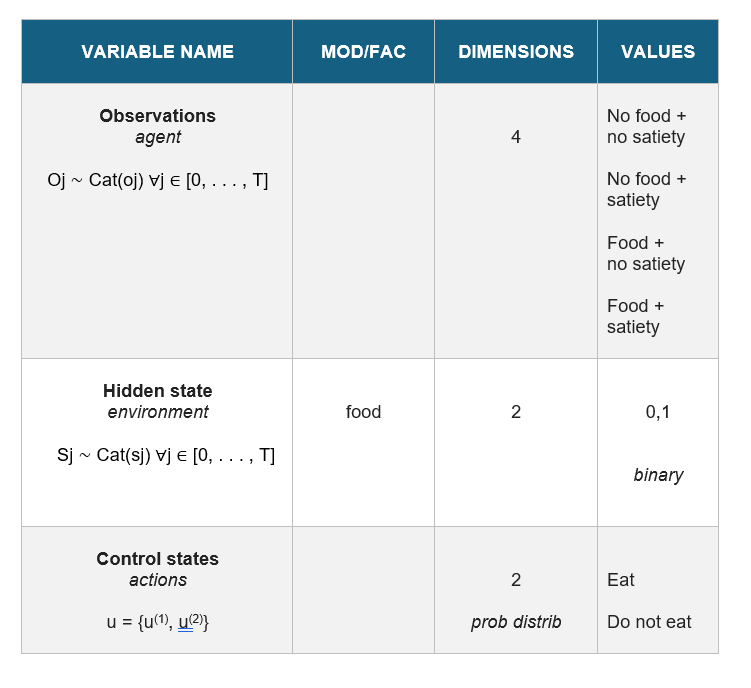

Setting dimensionalities

In [ ]:
 #hidden state
s_food = ['not present', 'present']

""" Define `num_states` and `num_factors` below """
num_states = [len(s_food)]
num_factors = len(num_states)

#control states
action1 = ['Do not eat'] #uncertainty
action2 = ['Eat']

""" Define `num_controls` below """
num_controls = [len(action1), len(action2)]

#observations
obs = ['no food and no satiety', 'no food and satiety', 'food and no satiety', 'food and satiety']

""" Define `num_obs` """
num_obs = [len(obs)]
num_modalities = len(num_obs)

In [ ]:
num_obs

[4]

In [ ]:
num_states

[2]

In [ ]:
num_modalities #for hidden state

1

In [ ]:
num_factors #for observation - maybe superfluous?

1

**A Matrix**

In [ ]:
""" Generate the A array """
#A = utils.initialize_empty_A(num_obs, num_states)

In [ ]:
p_obs1 = 0.7 #no food and no satiety

A_obs = np.zeros((len(obs), len(s_food)))

for food_id, s_food_value in enumerate(s_food):

  if s_food_value == 'not present':
    A_obs[0, food_id] = 1.0

  elif s_food_value == 'present':
    A_obs[1, food_id] = np.array([[p_obs1,  1.0 - p_obs1], #error
                                 [1.0 - p_obs1, p_obs1]])

  A[0] = A_obs

ValueError: setting an array element with a sequence.

or pymdp paper

In [ ]:
#model with 1 hidden state factor and 4 observation modality
n_obs = 12
n_states = 3
A = utils.obj_array(1)

In [ ]:
A = utils . obj_array (1)

In [ ]:
A[0] = np.array ([[1.0, 0.0, 0.0] ,
                  [0.0, 1.0, 0.0] ,
                  [0.0, 0.0, 1.0]])

##**Random stuff**

In [ ]:
#one time step of active inference
#observation = task_env.reset()
#qs = my_agent.infer_states(observation)
#q_pi = my_agent.infer_policies()
#chosen_action = my_agent.sample_action

In [ ]:
#get the observation given the action
#next_observation = task_env.step(chosen_action)

**1. MDP** - but we have to do PO

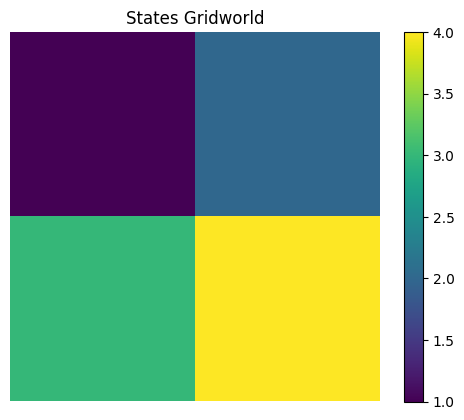

In [ ]:
states = np.linspace(1,4,4).reshape(2,2)
#print(states)

plt.imshow(states, cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.title('States Gridworld')
plt.show()

**2. Action space.** The agent move across the environment to collect rewards = find resources. There are 4 actions: move north, east, south or west

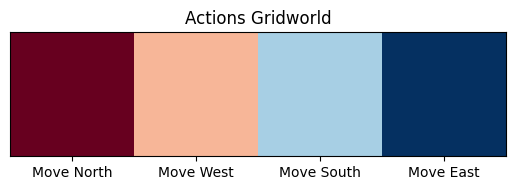

In [ ]:
actions = np.linspace(1,4,4).reshape(1,4)
#rint(actions)

plt.imshow(actions, cmap='RdBu')
plt.yticks([])
plt.xticks(np.arange(4), ['Move North', 'Move West', 'Move South','Move East'])
plt.title('Actions Gridworld')
plt.show()